In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
%matplotlib inline  

In [2]:
device_string = "/cpu:0"

### Loading data

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Defining model

In [4]:

with tf.device(device_string):
    x = tf.placeholder(tf.float32, [None, 784])
    ## Encoder

    with tf.variable_scope('encoder'):
        W_fc1 = tf.Variable(tf.random_uniform([784,50], dtype=tf.float32))
        b_fc1 = tf.Variable(tf.random_uniform([50], dtype=tf.float32)) 
        
        ## Bottleneck
        W_fc2 = tf.Variable(tf.random_uniform([50,2], dtype=tf.float32))
        b_fc2 = tf.Variable(tf.random_uniform([2], dtype=tf.float32)) 
    
        
        h1_enc = tf.nn.tanh(tf.matmul(x, W_fc1) + b_fc1)
        encoder_op = tf.nn.tanh(tf.matmul(h1_enc, W_fc2) + b_fc2)


    with tf.variable_scope('decoder'):

        code_in = tf.placeholder(tf.float32,[None,2])
        
        W_fc1 = tf.Variable(tf.random_uniform([2,50], dtype=tf.float32))
        b_fc1 = tf.Variable(tf.random_uniform([50], dtype=tf.float32)) 
        
        W_fc2 = tf.Variable(tf.random_uniform([50,784], dtype=tf.float32))
        b_fc2 = tf.Variable(tf.random_uniform([784], dtype=tf.float32)) 
        
        h1_dec = tf.nn.tanh(tf.matmul(encoder_op, W_fc1) + b_fc1)
        
        decode = tf.nn.tanh(tf.matmul(h1_dec, W_fc2) + b_fc2)
        
        h1_dec = tf.nn.tanh(tf.matmul(code_in, W_fc1) + b_fc1)

        decoder = tf.nn.tanh(tf.matmul(h1_dec, W_fc2) + b_fc2)
    


### Defining loss

In [5]:
with tf.device(device_string):
    y_ = tf.placeholder(tf.float32, [None, 784]) # Correct answer
    pv = tf.placeholder(tf.float32, [1, 2]) # Sparsity prob
    beta = tf.placeholder(tf.float32, [1, 1]) # Sparsity penalty (lagrange multiplier)

In [6]:
# Aditional loss for penalising high activations (http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/)
# with tf.device(device_string):
#     p = tf.nn.softmax(encoder_op)
#     kl_divergence = tf.reduce_mean(tf.mul(pv,tf.log(tf.div(pv,p))))
#     sparsity_loss = tf.mul(beta,kl_divergence)

In [7]:
with tf.device(device_string):
    weight_decay_loss = tf.add_n([tf.nn.l2_loss(v) for v in tf.trainable_variables()])
    squared_loss = tf.reduce_sum(tf.square(decode - y_)) 

In [8]:
with tf.device(device_string):
    loss_op = tf.reduce_mean(squared_loss) + 0.1*weight_decay_loss #+ sparsity_loss

In [9]:
with tf.device(device_string):
    train_op = tf.train.AdadeltaOptimizer(learning_rate=0.1, rho=0.1, epsilon=0.0001).minimize(loss_op)
    init_op = tf.initialize_all_variables()

### Training

In [10]:
sess = tf.Session()
with tf.device(device_string): 
    sess.run(init_op)

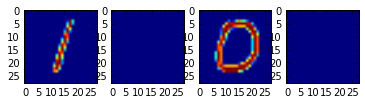

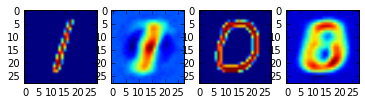

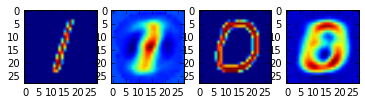

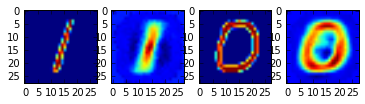

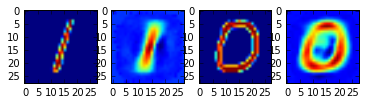

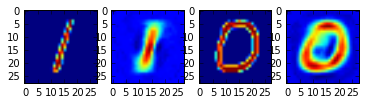

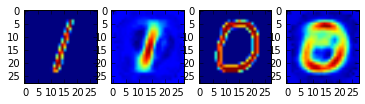

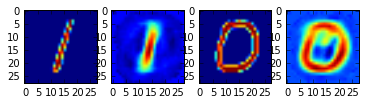

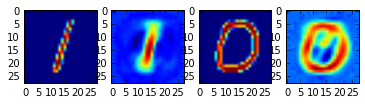

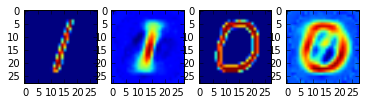

In [11]:
epochs = 10000
loss = [0]*epochs
with tf.device(device_string): 
    for i in range(epochs):
        batch_xs, _ = mnist.train.next_batch(100)
        #_, loss[i] = sess.run([train_op, loss_op], feed_dict={x: batch_xs, y_: batch_xs})
        _, loss[i] = sess.run([train_op, loss_op], feed_dict={x: batch_xs, y_: batch_xs, pv: [[0.02,0.98]], beta: [[0.1]]})
        
        if i%1000==0:
            idx = 2
            out_code, out_decode = sess.run([encoder_op,decode], feed_dict={x: np.expand_dims(mnist.test.images[idx,:],0)})
            plt.subplot(1,4,1)
            plt.imshow(np.reshape(mnist.test.images[idx,:],(28,28)))
            plt.subplot(1,4,2)
            plt.imshow(np.reshape(out_decode,(28,28)))
            
            idx = 10
            out_code, out_decode = sess.run([encoder_op,decode], feed_dict={x: np.expand_dims(mnist.test.images[idx,:],0)})
            plt.subplot(1,4,3)
            plt.imshow(np.reshape(mnist.test.images[idx,:],(28,28)))
            plt.subplot(1,4,4)
            plt.imshow(np.reshape(out_decode,(28,28)))
            
            plt.show()
        

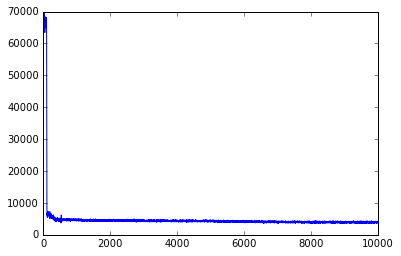

In [12]:
plt.plot(np.r_[loss].ravel())

# print np.r_[loss].ravel()

In [13]:
# print loss2[:10]
# plt.plot(np.r_[loss2].ravel())

Code: [[ 0.13225824 -0.20432849]] Label: [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


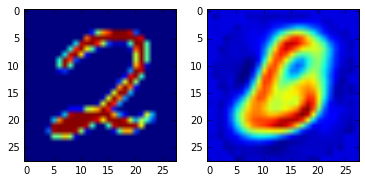

In [14]:
idx = 35

out_code, out_decode = sess.run([encoder_op, decode], feed_dict={x: np.expand_dims(mnist.test.images[idx,:],0)})
print "Code:", out_code, "Label:", mnist.test.labels[idx]

plt.subplot(1,2,1)
plt.imshow(np.reshape(mnist.test.images[idx,:],(28,28)))
plt.subplot(1,2,2)
plt.imshow(np.reshape(out_decode,(28,28)))

In [19]:
### Testing decoding

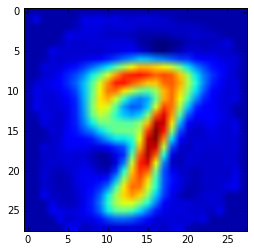

In [29]:
out_decode = sess.run([decoder], feed_dict={code_in: np.expand_dims(np.array([-0.8,-0.0]),0)})[0]

plt.imshow(np.reshape(out_decode,(28,28)))

In [28]:

with tf.device(device_string):
    out_code = sess.run([encoder_op], feed_dict={x: mnist.test.images})



In [16]:
print out_code[0].shape
xs = out_code[0][:,0]
ys = out_code[0][:,1]
ids = np.argmax(mnist.test.labels,1)
colours = np.random.rand(10)
colour = [ colours[idx] for idx in ids]

(10000, 2)


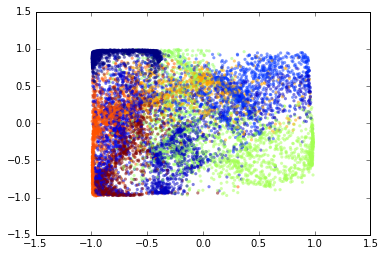

In [17]:
plt.scatter(xs, ys, s=10, c=colour, alpha=0.5,lw=0)
plt.show()